TODO: 

add some plotting

add way to determine clustering linkage distances

clean up later modules

put cluster selection into module

make cluster selection work with sparse inputs

chase down memory usage in cluster selection

# Setup

In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

In [2]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import natsort

import torch
# from kymatio.torch import Scattering2D

import gc
import time
import functools
import multiprocessing as mp


In [3]:
dir_save = '/home/rich/Desktop/'

In [4]:
params = {
    'paths': {
        'dir_github': r'/media/rich/Home_Linux_partition/github_repos/',
        'dir_allOuterFolders': r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16",
        'pathSuffixToStat': 'plane0/stat.npy',
        'pathSuffixToOps': 'plane0/ops.npy',
    },
    'prefs': {
        # 'pref_use_NN_distances': True,
        'use_GPU': True,
        # 'pref_blurROIs': True,
    },    
    'importing': {
        'data_verbose': True,
        'out_height_width': [36, 36],
        'max_footprint_width': 1025,
        'type_meanImg': 'meanImgE',
        'images': None,
        'import_workers': -1,
    },
    'alignment': {
        'method': 'createOptFlow_DeepFlow',
        'kwargs_method': None,
        'return_sparse': True,
        'normalize': True,
    },
    'blurring': {
        'kernel_halfWidth': 2.0,
        'device': 'cpu',
        'plot_kernel': False,
        'batch_size': 2000,
    },
    'ROInet': {
        'device': 'cuda:0',
        'dir_networkFiles': '/home/rich/Downloads/ROInet',
        'download_from_gDrive': 'check_local_first',
        'gDriveID': '1FCcPZUuOR7xG-hdO6Ei6mx8YnKysVsa8',
        'verbose': True,
        'goal_size': 250,
        'ptile_norm': 90,
        'scale_norm': 0.6,
        'pref_plot': False,
        'batchSize_dataloader': 8,
        'pinMemory_dataloader': True,
        'persistentWorkers_dataloader': True,
        'prefetchFactor_dataloader': 2,
    },
    'SWT': {
        'kwargs_Scattering2D': {'J': 2, 'L': 8},
        'image_shape': (36, 36),
        'device': 'cuda:0',
    }, 
    'similarity': {
        'device': 'cpu',
        'n_workers': -1,
        'spatialFootprint_maskPower': 0.8,
        'block_height': 50,
        'block_width': 50,
        'overlapping_width_Multiplier': 0.1,
        'algorithm_nearestNeigbors_spatialFootprints': 'brute',
        'n_neighbors_nearestNeighbors_spatialFootprints': 'full',
        'locality': 1,
        'verbose': True,
    },
    'similarity_compute': {
        'linkage_methods': ['single', 'complete', 'ward', 'average'],
        # 'linkage_distances': math_functions.bounded_logspace(0.05, 2, 50),
        'min_cluster_size': 2,
        'max_cluster_size': None,
        'batch_size_hashing': 100,
        'cluster_similarity_reduction_intra': 'mean',
        'cluster_similarity_reduction_inter': 'max',
        'cluster_silhouette_reduction_intra': 'mean',
        'cluster_silhouette_reduction_inter': 'max',
        'n_workers': 24,
        'power_clusterSize': 2,
        'power_clusterSilhouette': 1.5,
    },
    'clusterAssigner': {
        'device': 'cuda:0',
        'optimizer_partial_lr': 1e-1,
        'optimizer_partial_betas': (0.9, 0.900),
        'scheduler_partial_base_lr': 1e-3,
        'scheduler_partial_max_lr': 3e0,
        'scheduler_partial_step_size_up': 250,
        'scheduler_partial_cycle_momentum': False,
        'scheduler_partial_verbose': False,
        'dmCEL_temp': 1,
        'dmCEL_sigSlope': 2,
        'dmCEL_sigCenter': 0.5,
        'dmCEL_penalty': 1e0,
        'sampleWeight_softplusKwargs': {'beta': 150, 'threshold': 50},
        'sampleWeight_penalty': 1e3,
        'fracWeighted_goalFrac': 1.0,
        'fracWeighted_sigSlope': 2,
        'fracWeighted_sigCenter': 0.5,
        'fracWeight_penalty': 1e2,
        'maskL1_penalty': 2e-4,
        'tol_convergence': 1e-9,
        'window_convergence': 50,
        'freqCheck_convergence': 50,
        'verbose': True,       
    },
    'clusterAssigner_fit': {
        'min_iter': 1e3,
        'max_iter': 5e3,
        'verbose': True,
        'verbose_interval': 100,
        'm_threshold': 0.8,
    },
    'visualization': {
        'FOV_threshold_confidence': 0.5,
    }
}

In [5]:
dir_github = Path(params['paths']['dir_github']).resolve()

import sys
sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2
# from basic_neural_processing_modules import path_helpers, torch_helpers, featurization, indexing, misc, torch_helpers, plotting_helpers, classification, math_functions, parallel_helpers, clustering, image_processing, pickle_helpers, container_helpers
# from Big_Ugly_ROI_Tracker.multiEps.multiEps_modules import *
from registration_rClust import data_importing, visualization, alignment, blurring, helpers, ROInet, scatteringWaveletTransformer, similarity_graph, cluster_assignment


In [6]:
# params_all = [helpers.deep_update_dict(params, ['paths', 'dir_allOuterFolders'], val) for val in [
#         r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp6_3",
#         r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10",
#         r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp11",
#         r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp12",
#         r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp13",
#         r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16",
# ]]

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24234MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24234MB, multi_processor_count=82)
['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14']
['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14']
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D1
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D2
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D3
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D4
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D5


100%|███████████████████████████████████████████| 14/14 [00:02<00:00,  6.61it/s]


Converted 14 spatial footprint files into small centered images in self.ROI_images.
Imported 14 FOV images into class as self.FOV_images
Imported 14 sessions of spatial footprints into sparse arrays.


100%|███████████████████████████████████████████| 14/14 [04:09<00:00, 17.79s/it]


Successful hash comparison. Found matching files: {'params': '/home/rich/Downloads/ROInet/params.json', 'model': '/home/rich/Downloads/ROInet/model.py', 'state_dict': '/home/rich/Downloads/ROInet/ConvNext_tiny__1_0_unfrozen__simCLR.pth'}
Imported model from /home/rich/Downloads/ROInet/model.py
Loaded params_model from /home/rich/Downloads/ROInet/params.json


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from /home/rich/Downloads/ROInet/ConvNext_tiny__1_0_unfrozen__simCLR.pth
Loaded network onto device cuda:0
Starting: resizing ROIs


100%|███████████████████████████████████████████| 14/14 [00:06<00:00,  2.01it/s]


Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader
starting: running data through network


  0%|                                                  | 0/6397 [00:00<?, ?it/s]/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node 

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile informati

completed: running data through network
SWT initialized
Starting: SWT transform on ROIs
Completed: SWT transform on ROIs
Computing pairwise similarity between ROIs...


100%|█████████████████████████████████████████| 192/192 [04:59<00:00,  1.56s/it]


Removing duplicate clusters...
Starting: Making cluster spatial footprints
Completed: Making cluster spatial footprints
Starting: Computing cluster similarities


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/sparse/_umath.py:541: RuntimeWarning: invalid value encountered in true_divide
  fill_value_array = self.func(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/sparse/_umath.py:647: RuntimeWarning: divide by zero encountered in true_divide
  func_data = self.func(*func_args, dtype=self.dtype, **self.kwargs)


Completed: Computing cluster similarities
Starting: Computing modified cluster silhouettes


100%|██████████████████████████████████| 102561/102561 [02:43<00:00, 627.28it/s]


Completed: Computing modified cluster silhouettes


AssertionError: RH ERROR: the following must be true:  c.shape[0] == c.shape[1] == h.shape[0], they should all be n_clusters

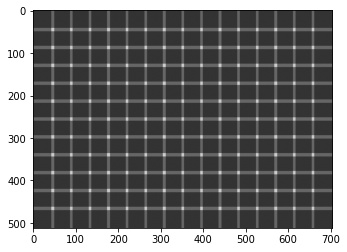

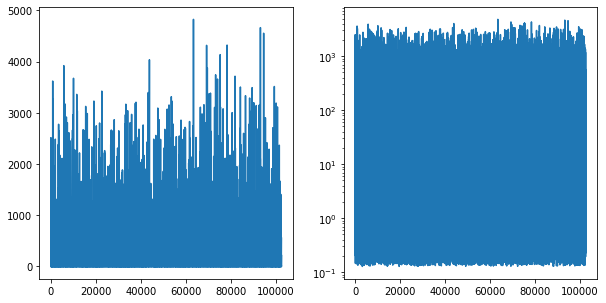

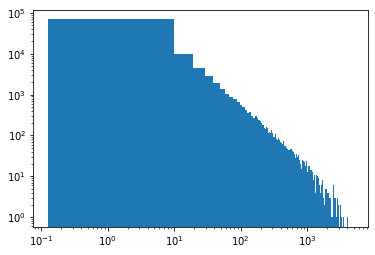

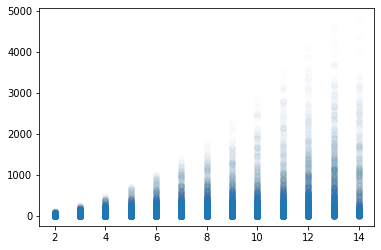

In [7]:
device = helpers.set_device(use_GPU=params['prefs']['use_GPU'])

# %matplotlib notebook


# Import paths
def print_list(l):
    for item in l:
        print(item)

dir_allOuterFolders = Path(params['paths']['dir_allOuterFolders']).resolve()

folders_allSessions = natsort.natsorted(helpers.get_dir_contents(dir_allOuterFolders)[0])

folders_toUse = folders_allSessions
# folders_toUse = list(map(folders_allSessions.__getitem__, [np.arange(1,9, dtype=np.int32)]))


# dir_allS2pFolders = [dir_allOuterFolders / folder / 'exp' / 'suite2p' / 'plane0' for folder in folders_toUse]
dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_toUse]

pathSuffixToStat = params['paths']['pathSuffixToStat']
pathSuffixToOps = params['paths']['pathSuffixToOps']

paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])[:]
paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])[:]

print(folders_allSessions)
print(folders_toUse)
print_list(dir_allS2pFolders)
print_list(paths_allStat)


#Import data
data = data_importing.Data_suite2p(
    paths_statFiles=paths_allStat,
    paths_opsFiles=paths_allOps,
    verbose=params['importing']['data_verbose'],
);

data.import_statFiles();

data.import_ROI_centeredImages(
    out_height_width=params['importing']['out_height_width'],
    max_footprint_width=params['importing']['max_footprint_width'],
);

data.import_FOV_images(
    type_meanImg=params['importing']['type_meanImg'],
    images=params['importing']['images'],
);

data.import_ROI_spatialFootprints(workers=params['importing']['import_workers']);

# visualization.display_toggle_image_stack(data.FOV_images)


# Alignment
aligner = alignment.Alinger(
    method=params['alignment']['method'],
    kwargs_method=params['alignment']['kwargs_method'],
)

aligner.register_ROIs(
    templateFOV=data.FOV_images[0],
    FOVs=data.FOV_images,
    ROIs=data.spatialFootprints,
    return_sparse=params['alignment']['return_sparse'],
    normalize=params['alignment']['normalize'],
);

# visualization.display_toggle_image_stack(aligner.FOVs_aligned)
# visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection())


# Blur ROIs (optional)
blurrer = blurring.ROI_Blurrer(
    frame_shape=(data.FOV_height, data.FOV_width),
    kernel_halfWidth=params['blurring']['kernel_halfWidth'],
    device=params['blurring']['device'],
    plot_kernel=params['blurring']['plot_kernel'],
)

blurrer.blur_ROIs(
    spatialFootprints=aligner.ROIs_aligned,
    batch_size=params['blurring']['batch_size'],
);

# visualization.display_toggle_image_stack(blurrer.get_ROIsBlurred_maxIntensityProjection())


# Neural network embedding distances
hash_dict_true = {
    'params': ('params.json', '877e17df8fa511a03bc99cd507a54403'),
    'model': ('model.py', '6ef5c29793ae16a64e43e8cab33d9ff4'),
    'state_dict': ('ConvNext_tiny__1_0_unfrozen__simCLR.pth', 'a5fae4c9ea95f2c78b4690222b2928a5'),
}

roinet = ROInet.ROInet_embedder(
    device=params['ROInet']['device'],
    dir_networkFiles=params['ROInet']['dir_networkFiles'],
    download_from_gDrive=params['ROInet']['download_from_gDrive'],
    gDriveID=params['ROInet']['gDriveID'],
    hash_dict_networkFiles=hash_dict_true,
    verbose=params['ROInet']['verbose'],
)

roinet.generate_dataloader(
    ROI_images=data.ROI_images,
    goal_size=params['ROInet']['goal_size'],
    ptile_norm=params['ROInet']['ptile_norm'],
    scale_norm=params['ROInet']['scale_norm'],
    pref_plot=params['ROInet']['pref_plot'],
    batchSize_dataloader=params['ROInet']['batchSize_dataloader'],
    pinMemory_dataloader=params['ROInet']['pinMemory_dataloader'],
    numWorkers_dataloader=mp.cpu_count(),
    persistentWorkers_dataloader=params['ROInet']['persistentWorkers_dataloader'],
    prefetchFactor_dataloader=params['ROInet']['prefetchFactor_dataloader'],    
)

roinet.generate_latents();

gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()


# Scattering wavelet embedding distances
swt = scatteringWaveletTransformer.SWT(
    kwargs_Scattering2D=params['SWT']['kwargs_Scattering2D'], 
    image_shape=params['SWT']['image_shape'], 
    device=params['SWT']['device'],
)

swt.transform(ROI_images=np.concatenate(data.ROI_images, axis=0));

# Compute similarities
sim = similarity_graph.ROI_graph(
    device=params['similarity']['device'],
    n_workers=params['similarity']['n_workers'],
    spatialFootprint_maskPower=params['similarity']['spatialFootprint_maskPower'],
    frame_height=data.FOV_height,
    frame_width=data.FOV_width,
    block_height=params['similarity']['block_height'],
    block_width=params['similarity']['block_width'],
    overlapping_width_Multiplier=params['similarity']['overlapping_width_Multiplier'],
    algorithm_nearestNeigbors_spatialFootprints=params['similarity']['algorithm_nearestNeigbors_spatialFootprints'],
    n_neighbors_nearestNeighbors_spatialFootprints=params['similarity']['n_neighbors_nearestNeighbors_spatialFootprints'],
    locality=params['similarity']['locality'],
    verbose=params['similarity']['verbose'],
)

sim.visualize_blocks()

sim.compute_similarity_blockwise(
    spatialFootprints=blurrer.ROIs_blurred,
    features_NN=roinet.latents,
    features_SWT=swt.latents,
    ROI_session_bool=data.sessionID_concat,
    linkage_methods=params['similarity_compute']['linkage_methods'],
    linkage_distances=helpers.bounded_logspace(0.05, 2, 50),
    min_cluster_size=params['similarity_compute']['min_cluster_size'],
    max_cluster_size=params['similarity_compute']['max_cluster_size'],
    batch_size_hashing=params['similarity_compute']['batch_size_hashing'],
);

sim.compute_cluster_similarity_graph(
        cluster_similarity_reduction_intra=params['similarity_compute']['cluster_similarity_reduction_intra'],
        cluster_similarity_reduction_inter=params['similarity_compute']['cluster_similarity_reduction_inter'],
        cluster_silhouette_reduction_intra=params['similarity_compute']['cluster_silhouette_reduction_intra'],
        cluster_silhouette_reduction_inter=params['similarity_compute']['cluster_silhouette_reduction_inter'],
        n_workers=params['similarity_compute']['n_workers'],
);

sim.compute_cluster_scores(
    power_clusterSize=params['similarity_compute']['power_clusterSize'], 
    power_clusterSilhouette=params['similarity_compute']['power_clusterSilhouette'],
);

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].plot(sim.scores.cpu())
# plt.ylim([0,1.1])
axs[1].plot(sim.scores.cpu())
axs[1].set_yscale('log')

plt.figure()
plt.hist(sim.scores.cpu(), 500)
plt.yscale('log')
plt.xscale('log')

plt.figure()
plt.scatter((np.array(sim.cluster_bool.sum(1)).squeeze()), sim.scores, alpha=0.01)

gc.collect()

torch.cuda.empty_cache()

gc.collect()

torch.cuda.empty_cache()

ca= cluster_assignment.Cluster_Assigner(
    c=sim.c_sim,
    h=sim.cluster_bool.T,
    w=sim.scores,
    device=params['clusterAssigner']['device'],
    m_init=(torch.ones(sim.c_sim.shape[0])*-5 + torch.rand(sim.c_sim.shape[0])*1).type(torch.float32),
    optimizer_partial=functools.partial(torch.optim.Adam, lr=params['clusterAssigner']['optimizer_partial_lr'], betas=params['clusterAssigner']['optimizer_partial_betas']),
    scheduler_partial=functools.partial(torch.optim.lr_scheduler.CyclicLR, base_lr=params['clusterAssigner']['scheduler_partial_base_lr'], max_lr=params['clusterAssigner']['scheduler_partial_max_lr'], step_size_up=params['clusterAssigner']['scheduler_partial_step_size_up'], cycle_momentum=params['clusterAssigner']['scheduler_partial_cycle_momentum'], verbose=params['clusterAssigner']['scheduler_partial_verbose']),
    dmCEL_temp=params['clusterAssigner']['dmCEL_temp'],
    dmCEL_sigSlope=params['clusterAssigner']['dmCEL_sigSlope'],
    dmCEL_sigCenter=params['clusterAssigner']['dmCEL_sigCenter'],
    dmCEL_penalty=params['clusterAssigner']['dmCEL_penalty'],
    sampleWeight_softplusKwargs=params['clusterAssigner']['sampleWeight_softplusKwargs'],
    sampleWeight_penalty=params['clusterAssigner']['sampleWeight_penalty'],
    fracWeighted_goalFrac=params['clusterAssigner']['fracWeighted_goalFrac'],
    fracWeighted_sigSlope=params['clusterAssigner']['fracWeighted_sigSlope'],
    fracWeighted_sigCenter=params['clusterAssigner']['fracWeighted_sigCenter'],
    fracWeight_penalty=params['clusterAssigner']['fracWeight_penalty'],
    maskL1_penalty=params['clusterAssigner']['maskL1_penalty'],
    tol_convergence=params['clusterAssigner']['tol_convergence'],
    window_convergence=params['clusterAssigner']['window_convergence'],
    freqCheck_convergence=params['clusterAssigner']['freqCheck_convergence'],
    verbose=params['clusterAssigner']['verbose'],
)

ca.fit(
    min_iter=params['clusterAssigner_fit']['min_iter'],
    max_iter=params['clusterAssigner_fit']['max_iter'],
    verbose=params['clusterAssigner_fit']['verbose'], 
    verbose_interval=params['clusterAssigner_fit']['verbose_interval'],
)

ca.plot_loss()

# del clusterAssigner

gc.collect()

torch.cuda.empty_cache()

gc.collect()

torch.cuda.empty_cache()

# clusterAssigner.plot_c_masked_matrix()

preds, confidence, scores_samples, m_bool = ca.predict(m_threshold=params['clusterAssigner_fit']['m_threshold'])
# preds, confidence, scores_samples, m_bool = clusterAssigner.predict(m_threshold=0.99)

ca.plot_clusterWeights()

ca.plot_sampleWeights()

ca.plot_clusterScores(bins=200)
# plt.xscale('log')
# plt.yscale('log')

fig, axs = ca.plot_labelCounts()
axs[0].set_ylim([0,20]);

print(f'Number of clusters: {m_bool.sum()}')



# visualization
FOV_clusters = visualization.compute_colored_FOV(
    spatialFootprints=aligner.ROIs_aligned,
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    preds=ca.preds,
    confidence=ca.confidence,
    threshold_confidence = params['visualization']['FOV_threshold_confidence'],
#     threshold_confidence = 0.99,
)

# %matplotlib notebook
# visualization.display_toggle_image_stack(FOV_clusters)

preds_by_session = [preds[idx].numpy() for idx in data.sessionID_concat.T]

ROIs = {
    "ROIs_aligned": aligner.ROIs_aligned,
    "ROIs_raw": data.spatialFootprints,
    "frame_height": data.FOV_height,
    "frame_width": data.FOV_width,
    "idx_roi_session": [np.where(idx)[0] for idx in data.sessionID_concat.T]
}

name_save = os.path.split(dir_allOuterFolders)[-1]
helpers.simple_save(
    {
        "UCIDs": list(ca.preds.numpy().astype(np.int64)),
        "UCIDs_bySession": preds_by_session,
        "ROIs": ROIs,
    },
    filename=Path(dir_save) / (name_save + '.plane0.rClust' '.pkl'),
#     filename='/media/rich/bigSSD/analysis_data/mouse 2_6/multiday_alignment/UCIDs.pkl'
)

gc.collect()

torch.cuda.empty_cache()

In [ ]:
# # %matplotlib notebook
# visualization.display_toggle_image_stack(FOV_clusters)


In [ ]:
# import numpy as np
# import scipy.sparse

# import torch_sparse as ts

# scipy.sparse.save_npz(
#     file=r'/home/rich/Desktop/c_sim.npz',
#     matrix=sim.c_sim.tocsr(),
#     compressed=True
# )
# scipy.sparse.save_npz(
#     file=r'/home/rich/Desktop/cluster_bool.npz',
#     matrix=sim.cluster_bool.tocsr(),
#     compressed=True
# )
# np.save(
#     file=r'/home/rich/Desktop/scores.npy',
#     arr=sim.scores.numpy(),
# )

# c_sim = scipy.sparse.load_npz(file=r'/home/rich/Desktop/c_sim.npz').tolil()
# cluster_bool = scipy.sparse.load_npz(file=r'/home/rich/Desktop/cluster_bool.npz').tocsr()
# scores = torch.as_tensor(np.load(file=r'/home/rich/Desktop/scores.npy'), dtype=torch.float32)